In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import DataCollatorForLanguageModeling
from transformers import AdamWeightDecay
from transformers import TFAutoModelForMaskedLM
from datasets import Dataset
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

2023-10-17 08:28:05.068521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 08:28:09.173819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def json_to_dataframe(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.iloc[0])
    f.close()
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x)) # Remove time stamps
    df['masked headline'] = df['masked headline'].str.replace('____', '<mask> ') # Replace ___ with <mask>
    df['text'] = df[['news', 'masked headline', 'calculation']].apply(" ".join, axis=1)
    #df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
    df = df.astype(str)
    return df

In [4]:
df = json_to_dataframe('Train_Numerical_Reasoning.json')
df.head()

news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object


,news,masked headline,calculation,ans,text
0,"As of Jan. 1, Walmart will no longer offer 30...",<mask> K Walmart Part-Timers to Lose Health In...,"Paraphrase(30,000,K)",30,"As of Jan. 1, Walmart will no longer offer 30..."
1,Dax Shepard and Kristen Bell got married at t...,Dax Shepard: Wedding to Kristen Bell Cost $<ma...,Copy(142),142,Dax Shepard and Kristen Bell got married at t...
2,"Nancy Reagan, the helpmate, backstage adviser...",Nancy Reagan Dead at <mask>,Copy(94),94,"Nancy Reagan, the helpmate, backstage adviser..."
3,American Airlines faces FAA fines of more tha...,American Airlines Faces $<mask> M Fine for Saf...,Copy(7),7,American Airlines faces FAA fines of more tha...
4,"Ingrid Lyne, the Seattle mom allegedly murder...",$<mask> K Raised for Kids of Mom Dismembered o...,"Paraphrase(222,000,K)",222,"Ingrid Lyne, the Seattle mom allegedly murder..."


In [5]:
df.shape

(21157, 5)

In [6]:
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)

To load a DistilRoBERTa tokenizer to process the text for masked language modeling, 

RoBERTa  (short for “Robustly Optimized BERT Approach”) is a variant of the BERT (Bidirectional Encoder Representations from Transformers) model. Like BERT, RoBERTa is a transformer-based language model that uses self-attention to process input sequences and generate contextualized representations of words in a sentence. But RoBERTa was trained on more than 10 times larger than the dataset used to train BERT (160GB of text). Also RoBERTa uses a dynamic masking technique during training that helps the model learn more robust and generalizable representations of words. 

In [7]:
model_name = "distilroberta-base"
#model_name = "Michau/t5-base-en-generate-headline"

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
def preprocess_function(examples):
    #return tokenizer([" ".join(x) for x in examples['text']]) # not join
    inputs = tokenizer(examples['text'],truncation=True)
    inputs['labels'] = examples['ans']
    return inputs

To apply the preprocess function over the entire dataset

In [10]:
tokenized = dataset.map(preprocess_function, batched=True, num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map (num_proc=4):   0%|          | 0/16925 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4232 [00:00<?, ? examples/s]

In [11]:
tokenized['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 16925
})

In [ ]:
'''
def preprocess_function(examples):   
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=max_len, truncation=True)
    labels = tokenizer(text_target=examples["ans"], max_length=max_l, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
'''

To create batches using DataCollatorForLanguageModeling, which dynamically pads the sentences to the longest length in a batch during collation. This is  more efficient than padding the whole dataset to the maximum length. To use the end-of-sequence token as the padding token and specify mlm_probability to randomly mask tokens each time iterated over the data.
Also, to set up optimizer function

In [13]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,  mlm_probability=0.15,return_tensors="tf")
#optimizer = AdamWeightDecay(learning_rate=3e-5, weight_decay_rate=0.01)
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

To load DistilRoBERTa with AutoModelForMaskedLM

In [14]:
model = TFAutoModelForMaskedLM.from_pretrained(model_name)

2023-10-17 08:29:17.738669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15520 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0b:00.0, compute capability: 6.0
All PyTorch model weights were used when initializing TFRobertaForMaskedLM.

All the weights of TFRobertaForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForMaskedLM for predictions without further training.


To convert datasets to the tf.data.Dataset format 

In [15]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [18]:
model.compile(optimizer=optimizer)

Perplexity to evaluate the model - to calculate the probabilities it assigns to the next word in all the sentences of the test set (the exponential of the cross-entropy loss is computed)

In [17]:
eval_loss = model.evaluate(tf_test_set)
print(f"Pretrained LM Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 39s 132ms/step - loss: 1.8290
Pretrained LM Perplexity: 6.23


In [19]:
history = model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=15)

Epoch 1/10
1057/1057 [==============================] - 795s 734ms/step - loss: 1.4701 - val_loss: 1.2865
Epoch 2/10
1057/1057 [==============================] - 770s 728ms/step - loss: 1.3886 - val_loss: 1.2643
Epoch 3/10
1057/1057 [==============================] - 769s 728ms/step - loss: 1.3567 - val_loss: 1.2611
Epoch 4/10
1057/1057 [==============================] - 770s 728ms/step - loss: 1.3393 - val_loss: 1.2423
Epoch 5/10
1057/1057 [==============================] - 769s 728ms/step - loss: 1.3121 - val_loss: 1.2289
Epoch 6/10
1057/1057 [==============================] - 769s 728ms/step - loss: 1.3049 - val_loss: 1.2362
Epoch 7/10
1057/1057 [==============================] - 769s 728ms/step - loss: 1.2913 - val_loss: 1.2319
Epoch 8/10
1057/1057 [==============================] - 769s 727ms/step - loss: 1.2692 - val_loss: 1.2223
Epoch 9/10
1057/1057 [==============================] - 770s 729ms/step - loss: 1.2591 - val_loss: 1.2219
Epoch 10/10
1057/1057 [=======================

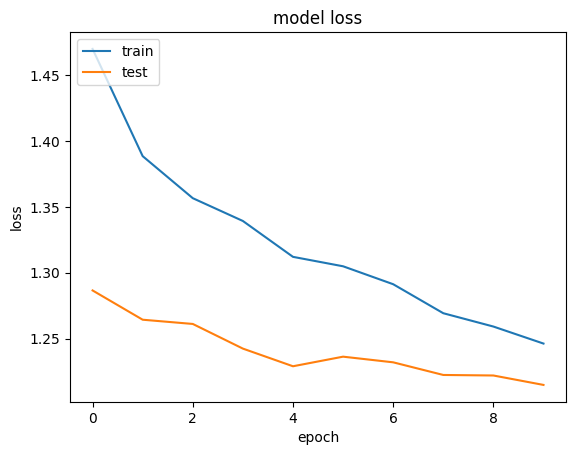

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
eval_loss = model.evaluate(tf_test_set)
print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 35s 134ms/step - loss: 1.3041
Finetuned Perplexity: 3.68


To use the model for dev dataset

In [21]:
f = open('Dev_Numerical_Reasoning.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df['masked headline'] = df['masked headline'].str.replace('____', '<mask> ')    
df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
df = df.astype(str)
#df = df.iloc[100:100]
f.close()
test_data = Dataset.from_pandas(df)

In [25]:
def predictions(data, tokenizer, model):
    inputs = tokenizer(data['text'], return_tensors="np")
    logits = model(**inputs).logits
    mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
    mask_token_logits = logits[0, mask_token_index, :]
    top_tokens = tf.math.top_k(mask_token_logits, 100).indices.numpy()
    result = ''
    for token in top_tokens:
        if tokenizer.decode([token][0]).strip() == data['ans']:
            result += tokenizer.decode([token][0]).strip()
            break
        else:
            pass
    if result == '':
        #result = data['text'].index
        #print("RESULT ", result)
        result = tokenizer.decode([tf.math.top_k(mask_token_logits, 1).indices.numpy()][0]).strip()
    return result

### Not Trained - RoBERTa 

In [13]:
tr = 0
false = []
for i in test_data:
    prediction = predictions(i, tokenizer, model)
    ans = i['ans']
    print("Prediction: ", prediction)
    print("Answer:     ", ans)
    print("Calculation: ", i['calculation'])
    if prediction == ans:
        tr += 1
    print("")


Prediction:  3
Answer:      3
Calculation:  Trans(three)

Prediction:  161
Answer:      12
Calculation:  Copy(12)

Prediction:  Against
Answer:      305
Calculation:  Round(305.45,0)

Prediction:  1
Answer:      1
Calculation:  Copy(1)

Prediction:  10
Answer:      10
Calculation:  Copy(10)

Prediction:  1959
Answer:      1959
Calculation:  Copy(1959)

Prediction:  218
Answer:      218
Calculation:  Copy(218)

Prediction:  
Answer:      9
Calculation:  Round(Divide(268,30),0)

Prediction:  2
Answer:      2
Calculation:  Paraphrase(2,000,K)

Prediction:  60
Answer:      60
Calculation:  Copy(60)

Prediction:  25
Answer:      25
Calculation:  Copy(25)

Prediction:  6
Answer:      6
Calculation:  Copy(6)

Prediction:  1
Answer:      1
Calculation:  Round(1.29,0)

Prediction:  4
Answer:      4
Calculation:  Copy(4)

Prediction:  3
Answer:      3
Calculation:  Trans(third)

Prediction:  30
Answer:      30
Calculation:  Copy(30)

Prediction:  20
Answer:      20
Calculation:  Copy(20)

Predic

In [20]:
tr/len(test_data)

0.55248833592535

### Finetuned - Top Prediction

In [22]:
# KOREKOREKORE
def predictions(data, tokenizer, model):
    inputs = tokenizer(data['text'], return_tensors="np")
    logits = model(**inputs).logits
    mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
    mask_token_logits = logits[0, mask_token_index, :]
    top_tokens = tf.math.top_k(mask_token_logits, 100).indices.numpy()
    result = ''
    for token in top_tokens:
        if tokenizer.decode([token][0]).strip().isdigit():
            result += tokenizer.decode([token][0]).strip()
            break
        else:
            pass
    if result == '':
        #result = data['text'].index
        #print("RESULT ", result)
        result = tokenizer.decode([tf.math.top_k(mask_token_logits, 1).indices.numpy()][0]).strip()
    return result

In [28]:
tr = 0
false = []
for i in test_data:
    prediction = predictions(i, tokenizer, model)
    ans = i['ans']
    print("Prediction: ", prediction)
    print("Answer:     ", i['ans'])
    print("Calc: ", i['calculation'])
    if prediction == ans:
        tr += 1
    print("")

Prediction:  3
Answer:      3
Calc:  Trans(three)

Prediction:  161
Answer:      12
Calc:  Copy(12)

Prediction:  305
Answer:      305
Calc:  Round(305.45,0)

Prediction:  1
Answer:      1
Calc:  Copy(1)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  1959
Answer:      1959
Calc:  Copy(1959)

Prediction:  218
Answer:      218
Calc:  Copy(218)

Prediction:  9
Answer:      9
Calc:  Round(Divide(268,30),0)

Prediction:  2
Answer:      2
Calc:  Paraphrase(2,000,K)

Prediction:  60
Answer:      60
Calc:  Copy(60)

Prediction:  25
Answer:      25
Calc:  Copy(25)

Prediction:  6
Answer:      6
Calc:  Copy(6)

Prediction:  1
Answer:      1
Calc:  Round(1.29,0)

Prediction:  4
Answer:      4
Calc:  Copy(4)

Prediction:  3
Answer:      3
Calc:  Trans(third)

Prediction:  30
Answer:      30
Calc:  Copy(30)

Prediction:  20
Answer:      20
Calc:  Copy(20)

Prediction:  5
Answer:      5
Calc:  Trans(five)

Prediction:  55
Answer:      55
Calc:  Copy(55)

Prediction:  65
Answer:      

In [ ]:
#optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)
#history = model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=16, epochs=3)

In [27]:
tr/len(test_data)

0.8118195956454122

### Finetuned - Top 25 Prediction

In [26]:
tr = 0
false = []
for i in test_data:
    prediction = predictions(i, tokenizer, model)
    ans = i['ans']
    print("Prediction: ", prediction)
    print("Answer:     ", ans)
    print("Calculation: ", i['calculation'])
    if prediction == ans:
        tr += 1
    print("")

Prediction:  3
Answer:      3
Calculation:  Trans(three)

Prediction:  161
Answer:      12
Calculation:  Copy(12)

Prediction:  305
Answer:      305
Calculation:  Round(305.45,0)

Prediction:  1
Answer:      1
Calculation:  Copy(1)

Prediction:  10
Answer:      10
Calculation:  Copy(10)

Prediction:  1959
Answer:      1959
Calculation:  Copy(1959)

Prediction:  218
Answer:      218
Calculation:  Copy(218)

Prediction:  9
Answer:      9
Calculation:  Round(Divide(268,30),0)

Prediction:  2
Answer:      2
Calculation:  Paraphrase(2,000,K)

Prediction:  60
Answer:      60
Calculation:  Copy(60)

Prediction:  25
Answer:      25
Calculation:  Copy(25)

Prediction:  6
Answer:      6
Calculation:  Copy(6)

Prediction:  1
Answer:      1
Calculation:  Round(1.29,0)

Prediction:  4
Answer:      4
Calculation:  Copy(4)

Prediction:  3
Answer:      3
Calculation:  Trans(third)

Prediction:  30
Answer:      30
Calculation:  Copy(30)

Prediction:  20
Answer:      20
Calculation:  Copy(20)

Predictio

In [30]:
tr/len(test_data)

0.9179626749611197